In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import gzip
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


tfk = tf.keras
tfkl = tf.keras.layers

#verific ce versiune de TensorFlow rulez
print (tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("Număr GPU-uri disponibile:", len(gpu_devices))

if len(gpu_devices) > 0:
    print("GPU detectat cu succes!")
    print("Detalii GPU:", gpu_devices[0])
else:
    print("ATENȚIE: GPU-ul nu a fost detectat de TensorFlow.")


2025-07-16 14:57:53.757254: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 14:57:53.757920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 14:57:53.760140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 14:57:53.765819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752667073.774995   13848 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752667073.77

2.18.0
Număr GPU-uri disponibile: 0
ATENȚIE: GPU-ul nu a fost detectat de TensorFlow.


W0000 00:00:1752667075.236890   13848 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Modelul 1, prezicerea clasei de risk

In [2]:
data = pd.read_csv("college_student_management_data.csv",delimiter=',')

df_risk = data.copy()

Features = [
    "major", "gender", "age", "attendance_rate", 
    "avg_session_duration_minutes", "assignment_submission_rate", 
    "forum_participation_count", "video_completion_rate"
]
X_df = df_risk[Features]

# One-Hot Encoding pentru 'major' și 'gender'
#adica ce fac este sa creez inca 3 coloane binare
# daca studentul este la arte spre exemplu, vine 1 in dreptul acelei coloana iar celellate sunt 0, se autoexclud, acelasi rationament
X_df_encoded = pd.get_dummies(X_df, columns=['major', 'gender'], drop_first=True)

# Scalare cu RobustScaler
scaler_x = RobustScaler()
x_features_scaled = scaler_x.fit_transform(X_df_encoded)


label_encoder = LabelEncoder()
y_target_en = label_encoder.fit_transform(df_risk['risk_level'])



print("Clasele pentru Nivelul de Risc:", label_encoder.classes_)


Clasele pentru Nivelul de Risc: ['High' 'Low' 'Medium']


In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x_features_scaled, y_target_en, 
    test_size=0.3, 
    random_state=45,
    stratify=y_target_en # Important pentru a păstra distribuția claselor
)



In [4]:

print(f"\\nDimensiuni X_train: {x_train.shape}")
print(x_train)
print(f"Dimensiuni y_train: {y_train.shape}")


\nDimensiuni X_train: (1081, 11)
[[ 0.5        -0.9         0.51219512 ...  0.          0.
   1.        ]
 [-0.75       -0.25       -0.46341463 ...  0.          1.
   0.        ]
 [ 0.75       -0.2        -0.04878049 ...  0.          0.
   0.        ]
 ...
 [-1.         -0.25       -0.17073171 ...  0.          0.
   0.        ]
 [ 0.5        -0.85       -0.17073171 ...  0.          1.
   0.        ]
 [ 0.75        1.         -0.68292683 ...  0.          0.
   0.        ]]
Dimensiuni y_train: (1081,)


In [5]:
input_dim = x_train.shape[1]
num_class = len(label_encoder.classes_) #am clasele Low, Medium,High

print(f"Modelul va fi construit pentru a accepta {input_dim} caracteristici de intrare.")

epochs = 400
batch_size = 32
opt = tfk.optimizers.Adam(learning_rate=1e-4)

model_risk = tfk.Sequential ([
        tfkl.InputLayer(input_shape=(input_dim,)),
    tfkl.Dense(100, activation = "relu", name = "Hidden_Layer_1", kernel_initializer = "random_uniform", bias_initializer = "random_uniform"),
    tfkl.Dense(num_class ,activation='softmax', name = "Output_layer")
])

model_risk.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model_risk.summary()

history_risk = model_risk.fit(
    x=x_train,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.25, # O modalitate simplă de a crea un set de validare
    shuffle=True
)

Modelul va fi construit pentru a accepta 11 caracteristici de intrare.


/home/glosper/anaconda3/envs/tf217/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 100)            │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,503 (5.87 KB)

 Trainable params: 1,503 (5.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2900 - loss: 1.1014 - val_accuracy: 0.3801 - val_loss: 1.0925
Epoch 2/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4013 - loss: 1.0897 - val_accuracy: 0.5092 - val_loss: 1.0794
Epoch 3/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4981 - loss: 1.0774 - val_accuracy: 0.5314 - val_loss: 1.0665
Epoch 4/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5206 - loss: 1.0669 - val_accuracy: 0.5203 - val_loss: 1.0545
Epoch 5/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5288 - loss: 1.0538 - val_accuracy: 0.5240 - val_loss: 1.0424
Epoch 6/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5403 - loss: 1.0368 - val_accuracy: 0.5240 - val_loss: 1.0306
Epoch 7/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.5114 - loss: 1.0328 - val_accuracy: 0.5240 - val_loss: 1.0194
Epoch 8/400
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5023 - loss: 1.0225 - val_accuracy: 0.5203

In [6]:

def evalueaza_model_multiclasa(y_test, y_pred_proba, label_encoder):
    """
    Evaluează și vizualizează performanța unui model de clasificare multi-clasă.
    """
    # --- Conversia probabilităților în clasa cu cea mai mare probabilitate ---
    y_pred_clasa = np.argmax(y_pred_proba, axis=1)
    
    # --- Raport de Performanță ---
    print("--- RAPORT DE PERFORMANȚĂ (CLASIFICARE MULTI-CLASĂ) ---\n")
    print("Raport de Clasificare Detaliat:")
    print(classification_report(y_test, y_pred_clasa, target_names=label_encoder.classes_))
    
    # --- Vizualizări ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Matricea de Confuzie
    cm = confusion_matrix(y_test, y_pred_clasa)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax1,
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    ax1.set_title('Matricea de Confuzie', fontsize=16)
    ax1.set_ylabel('Valoare Reală', fontsize=12)
    ax1.set_xlabel('Valoare Prezisă', fontsize=12)

    
    # 1. Inițializăm binarizatorul
    lb = LabelBinarizer()

    # 2. Îl "învățăm" pe toate clasele posibile și transformăm y_test
    #    Folosim y_train pentru a fi siguri că binarizatorul cunoaște toate clasele
    lb.fit(y_train) 
    y_test_binarized = lb.transform(y_test)
    
    # Plotează curba ROC pentru fiecare clasă
    for i, class_name in enumerate(label_encoder.classes_):
        # Asigură-te că există predicții pentru clasa curentă
        if i < y_pred_proba.shape[1]:
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            auc = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
            ax2.plot(fpr, tpr, lw=2, label=f'ROC pt. clasa {class_name} (AUC = {auc:.2f})')
        
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlabel('Rata Fals Pozitivelor (FPR)', fontsize=12)
    ax2.set_ylabel('Rata Adevărat Pozitivelor (TPR)', fontsize=12)
    ax2.set_title('Curbe ROC Multi-clasă (One-vs-Rest)', fontsize=16)
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- RAPORT DE PERFORMANȚĂ (CLASIFICARE MULTI-CLASĂ) ---

Raport de Clasificare Detaliat:
              precision    recall  f1-score   support

        High       0.89      0.69      0.78       242
         Low       0.49      0.67      0.57        85
      Medium       0.57      0.67      0.62       137

    accuracy                           0.68       464
   macro avg       0.65      0.68      0.65       464
weighted avg       0.72      0.68      0.69       464



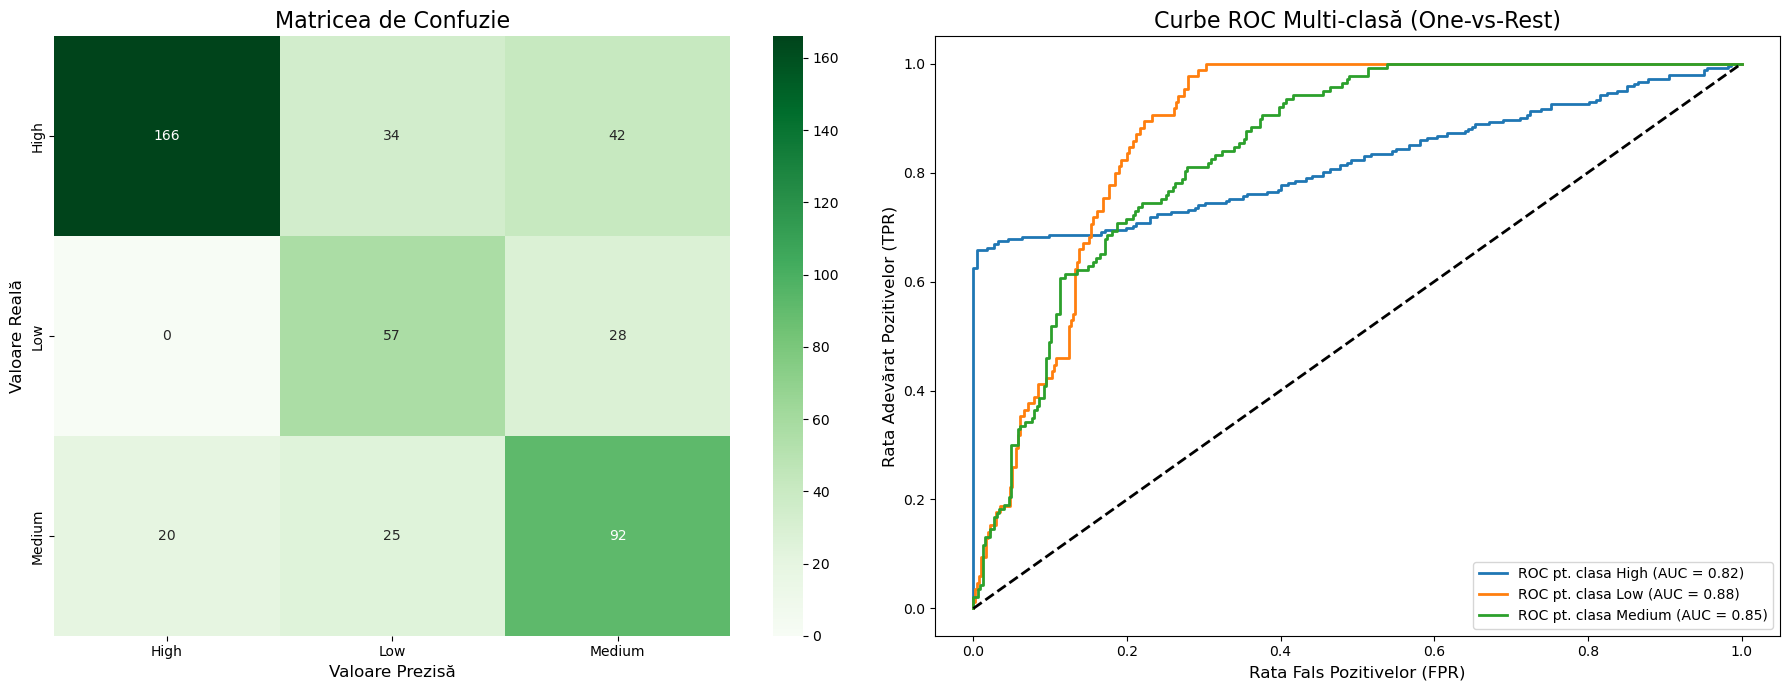

In [7]:
y_pred_risk = model_risk.predict(x_test)
evalueaza_model_multiclasa(y_test,y_pred_risk,label_encoder)

Modelul 2, pentru clasificarea sanselor de succes

In [92]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd

In [93]:
df_success = df_success[df_success['enrollment_status'].isin(['Graduated', 'Leave'])]

# Definim succesul: Absolvent CU un GPA bun
#Mai jos am stabilit niste criterii arbitrare pentru eticheta 'high_prospect' pe care am inventat-o fiindca ea nu exista
gpa_threshold = 3.0 
df_success['high_prospect'] = ((df_success['enrollment_status'] == 'Graduated') & (df_success['GPA'] > gpa_threshold)).astype(int)

# Selectăm variabilele
y_target_success = df_success[['high_prospect']].values

features_list = [
    "major", "gender", "age", "attendance_rate", 
    "avg_session_duration_minutes", "assignment_submission_rate", 
    "forum_participation_count", "video_completion_rate"
]
X_df_success = df_success[features_list]

# --- Pasul 2: Crearea Pipeline-ului de Preprocesare ---
#Aici am pus features-ul in 2 clase, categorical care sunt stringrui si numerice
categorical_features = ["major", "gender"]
numerical_features = ["age", "attendance_rate", "avg_session_duration_minutes", 
                      "assignment_submission_rate", "forum_participation_count", "video_completion_rate"]

#Pentru coloanele care sunt numere,situatia e mai simpla, putem face orice operatie de normalizare convenabila, am folosit RobustScaler,dar putem folosi ce dorim aici
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

#Situatia in care trebuie sa interpretam si sa normalizam coloane categorice precum gen, major si asa mai departe
#Atentie nu folosim labelTransform, deoarece ar fi o greseala sa facem distinctia dintre Art si Comp Sci la modul important, adica sa facem o ierarhie de tip 0,1,2
#ci pur si simplu creem coloane care sa ne spuna un atribut, e ceva ce descrie
#Cream mai multe coloane pentru fiecare categorii cu valori binare. Spre exemplu:
#Daca un student este la computer science, el va avea codul 0100, intrucat major s-a spart in major_Arts, majo_COMPUTER, major_Business,major_ce_o_mai_fi, una din astea primeste 1, automat celelalte se fac 0
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

Separ setul de date in date de antrenare si date de test

In [95]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(
    X_df_success, y_target_success, 
    test_size=0.3, 
    random_state=42,
    stratify=y_target_success
)

Aplic procesearea facuta anterior astfel incat sa am tipul de date adecvat

In [96]:
x_train_processed_s = preprocessor.fit_transform(x_train_s)
x_test_processed_s = preprocessor.transform(x_test_s)

print(f"Dimensiuni X_train_s după procesare: {x_train_processed_s.shape}")
print(f"Dimensiuni y_train_s: {y_train_s.shape}")

print("Inainte de procesare \n")
print(x_train_s)
print("Dupa procesare \n")
print(x_train_processed_s)



Dimensiuni X_train_s după procesare: (703, 11)
Dimensiuni y_train_s: (703, 1)
Inainte de procesare 

                 major  gender  age  attendance_rate  \
392   Computer Science  Female   25             0.79   
1419       Engineering  Female   18             0.80   
1265          Business   Other   20             0.84   
980           Business  Female   21             0.67   
1230              Arts  Female   24             0.79   
...                ...     ...  ...              ...   
1338              Arts    Male   23             0.71   
81                Arts   Other   21             0.87   
591        Engineering   Other   25             0.90   
1241              Arts    Male   21             0.74   
791               Arts  Female   25             0.96   

      avg_session_duration_minutes  assignment_submission_rate  \
392                             72                        0.85   
1419                            51                        0.57   
1265                        

In [ ]:
#Aici nu hardcodez, si iau numarul de parametrii distinctii din ca intrare, adica 11 , vezi mai sus
input_dim_s = x_train_processed_s.shape[1]

model_succes = tf.keras.Sequential([
    tfkl.InputLayer(input_shape=(input_dim_s,)),
    tfkl.Dense(128, activation='relu', name="Hidden_Layer_S1"),
    tfkl.Dense(64, activation='relu', name="Hidden_Layer_S2"),
    #Neuronul de activare sigmoid, care va scoate o probabilitate
    tfkl.Dense(1, activation='sigmoid', name="Output_Layer_Success")
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_succes.compile(
    optimizer=opt, 
    loss='binary_crossentropy', # Loss pentru clasificare binară
    metrics=['accuracy']
)

model_succes.summary()

epochs = 300
batch_size = 32

history_succes = model_succes.fit(
    x=x_train_processed_s, 
    y=y_train_s,           
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=True
)

/home/alexandru/anaconda3/envs/tf216/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_S1 (Dense)         │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_S2 (Dense)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer_Success (Dense)    │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5570 - loss: 0.6866 - val_accuracy: 0.6099 - val_loss: 0.6764
Epoch 2/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6027 - loss: 0.6768 - val_accuracy: 0.6525 - val_loss: 0.6653
Epoch 3/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6825 - loss: 0.6596 - val_accuracy: 0.6738 - val_loss: 0.6560
Epoch 4/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7065 - loss: 0.6449 - val_accuracy: 0.7092 - val_loss: 0.6474
Epoch 5/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7182 - loss: 0.6356 - val_accuracy: 0.7163 - val_loss: 0.6402
Epoch 6/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7532 - loss: 0.6169 - val_accuracy: 0.7163 - val_loss: 0.6344
Epoch 7/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7529 - loss: 0.6133 - val_accuracy: 0.7163 - val_loss: 0.6291
Epoch 8/300
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7486 - loss: 0.6056 - val_accuracy: 0.7163 - 

KeyboardInterrupt: 

In [108]:
def evalueaza_model_binar(y_test, y_pred_proba):
    """
    Evaluează și vizualizează performanța unui model de clasificare binară.
    """
    
    # --- Pasul 1: Conversia probabilităților în clase (0 sau 1) ---
    
    # CORECȚIA ESTE AICI: Convertim tensorul TensorFlow într-un array NumPy
    y_pred_proba_numpy = y_pred_proba.numpy()
    
    # Acum aplicăm pragul pe array-ul NumPy
    y_pred_clasa = (y_pred_proba_numpy > 0.5).astype(int)

    # --- Pasul 2: Raport de Performanță ---
    print("--- RAPORT DE PERFORMANȚĂ (CLASIFICARE BINARĂ) ---\n")
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Scorul AUC: {auc:.4f}")
    print("\nRaport de Clasificare Detaliat:")
    print(classification_report(y_test, y_pred_clasa, target_names=['Șanse Scăzute (0)', 'Șanse Ridicate (1)']))

    # --- Pasul 3: Vizualizări ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Matricea de Confuzie
    cm = confusion_matrix(y_test, y_pred_clasa)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Șanse Scăzute', 'Șanse Ridicate'], 
                yticklabels=['Șanse Scăzute', 'Șanse Ridicate'])
    ax1.set_title('Matricea de Confuzie', fontsize=16)
    ax1.set_ylabel('Valoare Reală', fontsize=12)
    ax1.set_xlabel('Valoare Prezisă', fontsize=12)

    # Curba ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curba ROC (AUC = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlabel('Rata Fals Pozitivelor (FPR)', fontsize=12)
    ax2.set_ylabel('Rata Adevărat Pozitivelor (TPR)', fontsize=12)
    ax2.set_title('Curba ROC', fontsize=16)
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

--- RAPORT DE PERFORMANȚĂ (CLASIFICARE BINARĂ) ---

Scorul AUC: 0.4690

Raport de Clasificare Detaliat:
                    precision    recall  f1-score   support

 Șanse Scăzute (0)       0.73      0.97      0.83       220
Șanse Ridicate (1)       0.25      0.02      0.04        82

          accuracy                           0.72       302
         macro avg       0.49      0.50      0.44       302
      weighted avg       0.60      0.72      0.62       302



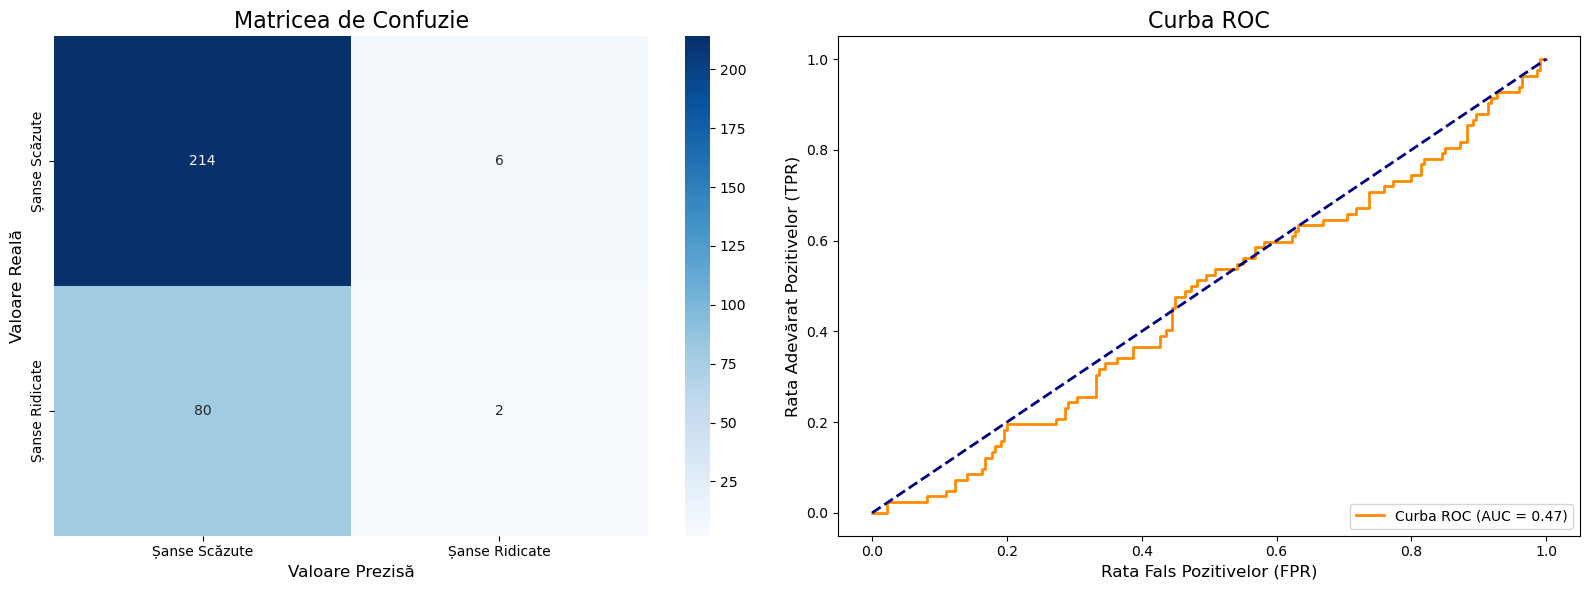

In [109]:
y_pred_s = model_succes(x_test_processed_s)
evalueaza_model_binar(y_test_s,y_pred_s)

Curba de invatare

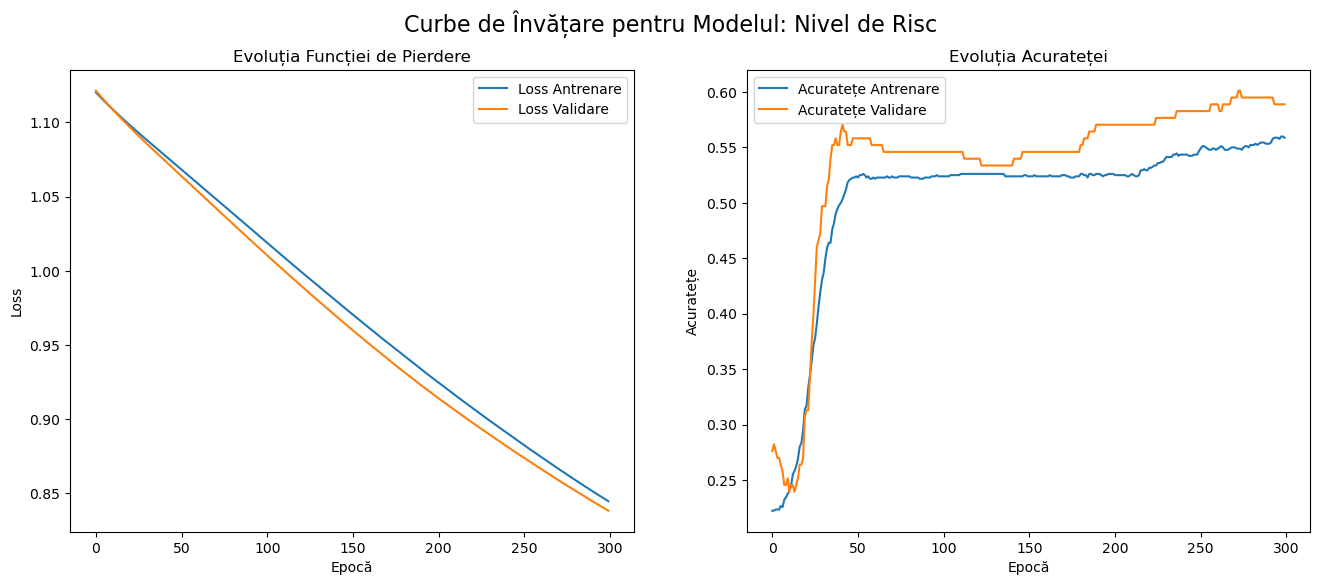

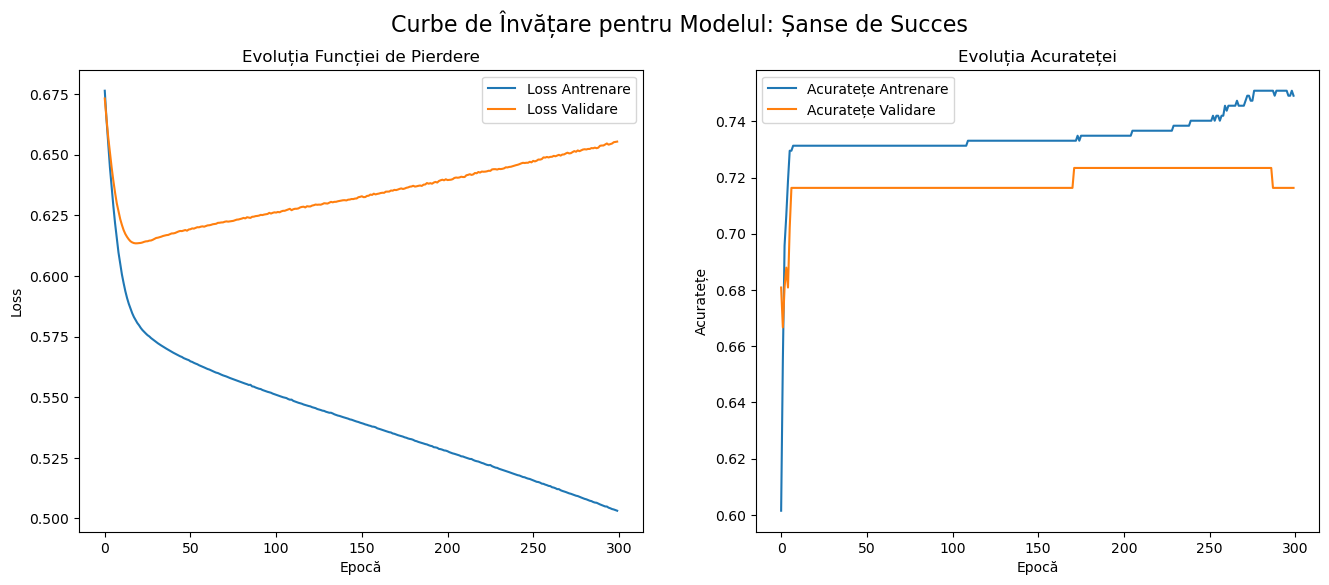

In [110]:
def ploteaza_curbe_invatare(history, model_name):
    """
    Plotează curbele de loss și acuratețe pentru antrenare și validare.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Curbe de Învățare pentru Modelul: {model_name}', fontsize=16)

    # Graficul pentru Loss
    ax1.plot(history.history['loss'], label='Loss Antrenare')
    ax1.plot(history.history['val_loss'], label='Loss Validare')
    ax1.set_title('Evoluția Funcției de Pierdere')
    ax1.set_xlabel('Epocă')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Graficul pentru Acuratețe
    ax2.plot(history.history['accuracy'], label='Acuratețe Antrenare')
    ax2.plot(history.history['val_accuracy'], label='Acuratețe Validare')
    ax2.set_title('Evoluția Acurateței')
    ax2.set_xlabel('Epocă')
    ax2.set_ylabel('Acuratețe')
    ax2.legend()
    
    plt.show()

ploteaza_curbe_invatare(history_risk, "Nivel de Risc")
ploteaza_curbe_invatare(history_succes, "Șanse de Succes")